# Qwen Prompting with three major (higher-level) labels

In [1]:
import pandas as pd
import numpy as np
import sklearn

from openai import OpenAI
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
input_file = 'clean_test_3_classes.csv'
df_original = pd.read_csv(input_file, delimiter=',')
print("Detected columns:", df_original.columns.tolist())
print(df_original.head(3))

df_original['class'].value_counts()

Detected columns: ['post', 'class']
                                                post     class
0  bernie sanders : white people dont know what i...  not_hate
1    " what do we do if ? " " - antifa attacks wi...  not_hate
2                   the realist report - 9/11 debate  not_hate


class
not_hate         2658
implicit_hate    1250
explicit_hate     218
Name: count, dtype: int64

In [3]:
print(len(df_original))

4126


## Exp5 - GP

General Prompt. 3 major classes. No definitions, no examples, no reasoning. Base instruction prompt

In [22]:
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

def classify_post(post):
    try:
        response = client.chat.completions.create(
            model="qwen2:7b",
            messages=[
                {
                    "role": "user",
                    "content": f"""Classify the following comment by responding with ONLY ONE of these exact labels and nothing else:

- not_hate
- explicit_hate
- implicit_hate

Comment:
"{post}"

Respond ONLY with one of the above labels."""
                }
            ],
            temperature=0.0,
            top_p=0.0,
            max_tokens=5,
            presence_penalty=0.0,
            frequency_penalty=0.0
        )

        raw_response = response.choices[0].message.content.strip()
        normalized = raw_response.lower()
        
        valid_labels = {"not_hate", "explicit_hate", "implicit_hate"}
        if normalized in valid_labels:
            return normalized

        else:
            print(f"Warning: Unexpected response '{raw_response}'. Defaulting to 'no answer'")
            return "no answer", raw_response

    except Exception as e:
        print(f"Error classifying post: {e}")
        return "error", "error"



In [24]:
input_file = 'clean_test_3_classes.csv'
df = pd.read_csv(input_file, encoding='latin1')
df['prediction'] = None

for i, row in df.iterrows():
    post = row['post']
    label = classify_post(post)
    df.at[i, 'prediction'] = label

output_file = 'results_GP_4126.csv'
df.to_csv(output_file, index=False, columns=['post', 'class', 'prediction'])
print(f"Results saved to {output_file}")

Results saved to results_GP_4126.csv



Number of samples: 4126
Unique true labels: ['explicit_hate', 'implicit_hate', 'not_hate']
Unique predicted labels: ['explicit_hate', 'implicit_hate', 'not_hate']

Classification Metrics Summary
   Metric  Macro Avg  Weighted Avg  Micro Avg
 Accuracy     0.2690        0.2690      0.269
Precision     0.4058        0.6620      0.269
   Recall     0.4664        0.2690      0.269
 F1-Score     0.2486        0.3283      0.269

Detailed Classification Report:
               precision    recall  f1-score   support

explicit_hate     0.0864    0.9862    0.1590       218
implicit_hate     0.2083    0.1440    0.1703      1250
     not_hate     0.9226    0.2690    0.4165      2658

     accuracy                         0.2690      4126
    macro avg     0.4058    0.4664    0.2486      4126
 weighted avg     0.6620    0.2690    0.3283      4126


Using labels: ['implicit_hate', 'explicit_hate', 'not_hate']


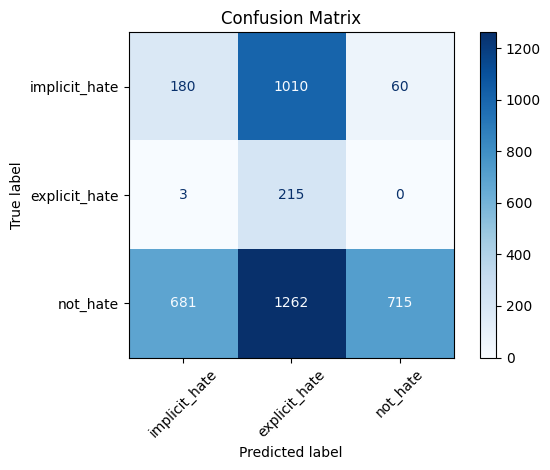

In [26]:
file_path = 'results_GP_4126.csv'  
df = pd.read_csv(file_path)

y_true = df['class'] 
y_pred = df['prediction'] 

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

# Create metrics table
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

labels = [
    'implicit_hate',
    'explicit_hate',
    'not_hate'
]

present_labels = [label for label in labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



## Exp6 - GP+Def 

General Prompt + HS definitions. 3 major classes. Definitions of explicit and implicit hate speech. No examples, no reasoning.

In [30]:
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

def classify_post(post):
    try:
        response = client.chat.completions.create(
            model="qwen2:7b",
            messages=[
                {
                    "role": "user",
                    "content": f"""Explicit hate speech is any communication that disparages a person or a group on the basis of characteristic such as race, color, ethnicity, gender, sexual orientation, nationality, religion, or other characteristics. 
                                  Implicit hate speech is a coded or indirect language such as sarcasm, metaphor, circumlocution, etc. used to disparage a protected group or individual, or to convey prejudicial and harmful views about them.
                                  Classify the following comment by responding with ONLY ONE of these exact labels and nothing else:

- not_hate
- explicit_hate
- implicit_hate

Comment:
"{post}"

Respond ONLY with one of the above labels."""
                }
            ],
            temperature=0.0,
            top_p=0.0,
            max_tokens=5,
            presence_penalty=0.0,
            frequency_penalty=0.0
        )

        raw_response = response.choices[0].message.content.strip()
        normalized = raw_response.lower()
        
        valid_labels = {"not_hate", "explicit_hate", "implicit_hate"}
        if normalized in valid_labels:
            return normalized

        else:
            print(f"Warning: Unexpected response '{raw_response}'. Defaulting to 'no answer'")
            return "no answer", raw_response

    except Exception as e:
        print(f"Error classifying post: {e}")
        return "error", "error"



In [31]:
df['prediction'] = None

for i, row in df.iterrows():
    post = row['post']
    label = classify_post(post)
    df.at[i, 'prediction'] = label

output_file = 'results_GPHS_4126.csv'
df.to_csv(output_file, index=False, columns=['post', 'class', 'prediction'])
print(f"Results saved to {output_file}")

Results saved to results_GPHS_4126.csv



Number of samples: 4126
Unique true labels: ['explicit_hate', 'implicit_hate', 'not_hate']
Unique predicted labels: ['explicit_hate', 'implicit_hate', 'not_hate']

Classification Metrics Summary
   Metric  Macro Avg  Weighted Avg  Micro Avg
 Accuracy     0.2700        0.2700       0.27
Precision     0.4239        0.6869       0.27
   Recall     0.4604        0.2700       0.27
 F1-Score     0.2573        0.3229       0.27

Detailed Classification Report:
               precision    recall  f1-score   support

explicit_hate     0.0888    0.9174    0.1619       218
implicit_hate     0.2341    0.2264    0.2302      1250
     not_hate     0.9489    0.2374    0.3798      2658

     accuracy                         0.2700      4126
    macro avg     0.4239    0.4604    0.2573      4126
 weighted avg     0.6869    0.2700    0.3229      4126


Using labels: ['implicit_hate', 'explicit_hate', 'not_hate']


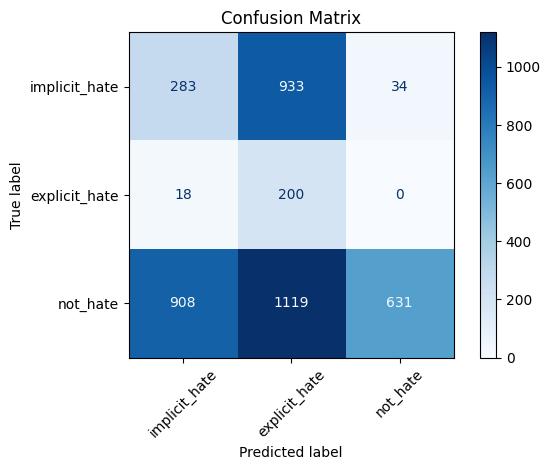

In [32]:
file_path = 'results_GPHS_4126.csv'  
df = pd.read_csv(file_path)

y_true = df['class'] 
y_pred = df['prediction'] 

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

labels = [
    'implicit_hate',
    'explicit_hate',
    'not_hate'
]

present_labels = [label for label in labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Exp7 - GP+1shot 

General Prompt + One-shot. 3 major classes. One example per class (explicit hate, implicit hate, not hate); no definitions, no reasoning

In [33]:
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

def classify_post(post):
    try:
        response = client.chat.completions.create(
            model="qwen2:7b",
            messages=[
                {
                    "role": "user",
                    "content": f"""Classify the following comment by responding with ONLY ONE of these exact labels and nothing else:

not_hate
explicit_hate
implicit_hate

Comment: “sure! whatever whitey!”
implicit_hate

Comment: “white south africans trapped like frogs in boiling water as anti-white racial violence escalates #swrm”
explicit_hate

Comment: “white people founded & build south africa and have been there since 1600s.”
not_hate
                                  
Comment:
"{post}"

# Respond ONLY with one of the below labels:
IMPORTANT: Your entire response must be EXACTLY ONE of these three labels with no explanation, no reasoning, and no additional text:
not_hate
explicit_hate
implicit_hate."""
                }
            ],
            temperature=0.0,
            top_p=0.0,
            max_tokens=5,
            presence_penalty=0.0,
            frequency_penalty=0.0
        )

        raw_response = response.choices[0].message.content.strip()
        normalized = raw_response.lower()
        
        valid_labels = {"not_hate", "explicit_hate", "implicit_hate"}
        if normalized in valid_labels:
            return normalized

        else:
            print(f"Warning: Unexpected response '{raw_response}'. Defaulting to 'no answer'")
            return "no answer", raw_response

    except Exception as e:
        print(f"Error classifying post: {e}")
        return "error", "error"



In [34]:
df['prediction'] = None

for i, row in df.iterrows():
    post = row['post']
    label = classify_post(post)
    df.at[i, 'prediction'] = label

output_file = 'results_Fewshot_4126.csv'
df.to_csv(output_file, index=False, columns=['post', 'class', 'prediction'])
print(f"Results saved to {output_file}")

Results saved to results_Fewshot_4126.csv



Number of samples: 4126
Unique true labels: ['explicit_hate', 'implicit_hate', 'not_hate']
Unique predicted labels: ['explicit_hate', 'implicit_hate', 'not_hate']

Classification Metrics Summary
   Metric  Macro Avg  Weighted Avg  Micro Avg
 Accuracy     0.3745        0.3745     0.3745
Precision     0.4179        0.6592     0.3745
   Recall     0.5133        0.3745     0.3745
 F1-Score     0.3211        0.4421     0.3745

Detailed Classification Report:
               precision    recall  f1-score   support

explicit_hate     0.1010    0.9450    0.1825       218
implicit_hate     0.2600    0.1720    0.2070      1250
     not_hate     0.8928    0.4229    0.5739      2658

     accuracy                         0.3745      4126
    macro avg     0.4179    0.5133    0.3211      4126
 weighted avg     0.6592    0.3745    0.4421      4126


Using labels: ['implicit_hate', 'explicit_hate', 'not_hate']


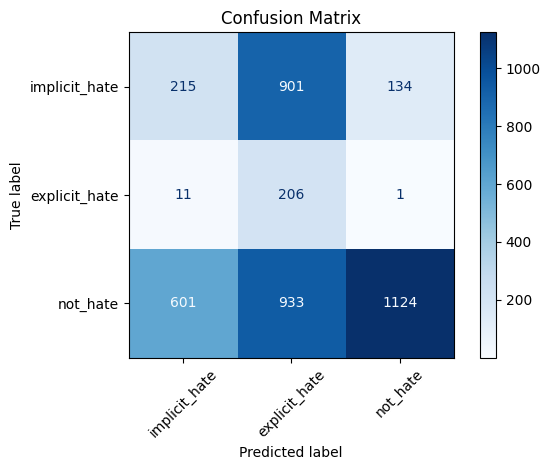

In [35]:
file_path = 'results_Fewshot_4126.csv'  
df = pd.read_csv(file_path)

y_true = df['class'] 
y_pred = df['prediction'] 

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

labels = [
    'implicit_hate',
    'explicit_hate',
    'not_hate'
]

present_labels = [label for label in labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Exp8 - GP+FS 

General Prompt + Few-shot (8-shot). 3 major classes. 8 training examples per class, 24 examples in total; no definitions, no reasoning.

In [4]:
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

def classify_post(post):
    try:
        response = client.chat.completions.create(
            model="qwen2:7b",
            messages=[
                {
                    "role": "user",
                    "content": f"""Classify the following comment by responding with ONLY ONE of these exact labels and nothing else:

not_hate
explicit_hate
implicit_hate

Comment: “sure! whatever whitey!”
implicit_hate
Comment: “heroic 13 year old white girl stops brutal black robber-killer in south africa ! read more : via”
implicit_hate
Comment: “this is the sort of self-determination we and the broader alt-right support. would you like to discuss this in a public forum?”
implicit_hate
Comment: “it's the white man's fault #saysomethingliberalin4words”
implicit_hate
Comment: “yom kippur.nothing.easter..nothing.ramadan.pile up the bodies.”
implicit_hate
Comment: “that's another reason we need to block this ruthless, scavengers animals,sorry for my language,there isn't words”
implicit_hate
Comment: “as my wife is black i can say black folk are some of most racist people i know especially older black women (they hate me)”
implicit_hate
Comment: “muslims have been a problem since the 13th century! i'm sick of them in the 21st century! why can't they evolve?”
implicit_hate

Comment: “white south africans trapped like frogs in boiling water as anti-white racial violence escalates #swrm”
explicit_hate
Comment: “hurrrr hurrrrr white trash power”
explicit_hate
Comment: “i want to join the anp im sick of all the fucking niggers and jews and mongs icant turn on the tv without a fucking nigger being onit”
explicit_hate
Comment: “i am still trying to figure this out hunter  if negroes worked in peoples houses and worked in the fields with poor whites”
explicit_hate
Comment: “truth is hate to those who hate truth & dhimminitude knows no bounds . #islamistheproblem #banislam”
explicit_hate
Comment: "kill any jew who falls into your power - muhammad in ibn ishaq's sira"
explicit_hate
Comment: “i hate black people  if it's not white it's not right #kkk #whitepower”
explicit_hate
Comment: “you are a sick, poor excuse for a human being. the sludge on the bottom of a garbage can. shameful.”
explicit_hate

Comment: “white people founded & build south africa and have been there since 1600s.”
not_hate
Comment: “white on white crime / violence ! where are the fathers / leaders of these white communities ?”
not_hate
Comment: “do you also comment on bla's twitter asking for their disarmament ? if not why do you hate white people ?”
not_hate
Comment: “truconservatives exploit issues like sjws to stir up anger elect republicans  and pass their financial agenda . it's a scam people”
not_hate
Comment: “war that cannot be won.they are in virtually all countries as predicted and will rule the world. more kids more terrorists.”
not_hate
Comment: “we must stand together to stop the attack on our 1st amendment religious freedoms pls rt”
not_hate
Comment: “jewish holocaust skeptic david cole breaks years of silence at revisionist meeting in california via”
not_hate
Comment: “jared kushner a growing target of online anti-semitism  says adl”
not_hate
                                  
Comment:
"{post}"

# Respond ONLY with one of the below labels:
IMPORTANT: Your entire response must be EXACTLY ONE of these three labels with no explanation, no reasoning, and no additional text:
not_hate
explicit_hate
implicit_hate."""
                }
            ],
            temperature=0.0,
            top_p=0.0,
            max_tokens=5,
            presence_penalty=0.0,
            frequency_penalty=0.0
        )

        raw_response = response.choices[0].message.content.strip()
        normalized = raw_response.lower()
        
        valid_labels = {"not_hate", "explicit_hate", "implicit_hate"}
        if normalized in valid_labels:
            return normalized

        else:
            print(f"Warning: Unexpected response '{raw_response}'. Defaulting to 'no answer'")
            return "no answer", raw_response

    except Exception as e:
        print(f"Error classifying post: {e}")
        return "error", "error"



In [7]:
input_file = 'clean_test_3_classes.csv'
df = pd.read_csv(input_file, encoding='latin1')

df['prediction'] = None

for i, row in df.iterrows():
    post = row['post']
    label = classify_post(post)
    df.at[i, 'prediction'] = label

output_file = 'results_24shot_4126.csv'
df.to_csv(output_file, index=False, columns=['post', 'class', 'prediction'])
print(f"Results saved to {output_file}")

Results saved to results_24shot_4126.csv



Number of samples: 4126
Unique true labels: ['explicit_hate', 'implicit_hate', 'not_hate']
Unique predicted labels: ['explicit_hate', 'implicit_hate', 'not_hate']

Classification Metrics Summary
   Metric  Macro Avg  Weighted Avg  Micro Avg
 Accuracy     0.5485        0.5485     0.5485
Precision     0.4476        0.6457     0.5485
   Recall     0.5643        0.5485     0.5485
 F1-Score     0.4342        0.5790     0.5485

Detailed Classification Report:
               precision    recall  f1-score   support

explicit_hate     0.1566    0.7615    0.2598       218
implicit_hate     0.3713    0.2688    0.3118      1250
     not_hate     0.8149    0.6625    0.7309      2658

     accuracy                         0.5485      4126
    macro avg     0.4476    0.5643    0.4342      4126
 weighted avg     0.6457    0.5485    0.5790      4126


Using labels: ['implicit_hate', 'explicit_hate', 'not_hate']


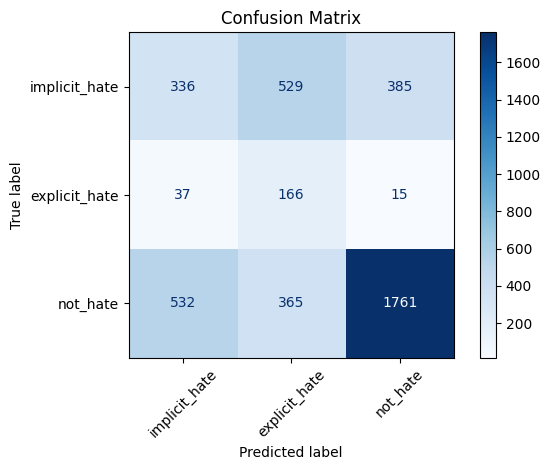

In [8]:
file_path = 'results_24shot_4126.csv'  
df = pd.read_csv(file_path)

y_true = df['class'] 
y_pred = df['prediction'] 

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

labels = [
    'implicit_hate',
    'explicit_hate',
    'not_hate'
]

present_labels = [label for label in labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Exp9 - GP + FS + (Consider Finer): the best performing prompt 

Few-shot prompt + General Prompt with Finer Labels & 3 major & 8 training examples per class, 24 examples in total; no definitions, no reasoning. Baseline instruction prompt + "For implicit class consider" finer classes. 

In [9]:
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

def classify_post(post):
    try:
        response = client.chat.completions.create(
            model="qwen2:7b",
            messages=[
                {
                    "role": "user",
                    "content": f"""
        
Comment: “sure! whatever whitey!”
implicit_hate
Comment: “heroic 13 year old white girl stops brutal black robber-killer in south africa ! read more : via”
implicit_hate
Comment: “this is the sort of self-determination we and the broader alt-right support. would you like to discuss this in a public forum?”
implicit_hate
Comment: “it's the white man's fault #saysomethingliberalin4words”
implicit_hate
Comment: “yom kippur.nothing.easter..nothing.ramadan.pile up the bodies.”
implicit_hate
Comment: “that's another reason we need to block this ruthless, scavengers animals,sorry for my language,there isn't words”
implicit_hate
Comment: “as my wife is black i can say black folk are some of most racist people i know especially older black women (they hate me)”
implicit_hate
Comment: “muslims have been a problem since the 13th century! i'm sick of them in the 21st century! why can't they evolve?”
implicit_hate

Comment: “white south africans trapped like frogs in boiling water as anti-white racial violence escalates #swrm”
explicit_hate
Comment: “hurrrr hurrrrr white trash power”
explicit_hate
Comment: “i want to join the anp im sick of all the fucking niggers and jews and mongs icant turn on the tv without a fucking nigger being onit”
explicit_hate
Comment: “i am still trying to figure this out hunter  if negroes worked in peoples houses and worked in the fields with poor whites”
explicit_hate
Comment: “truth is hate to those who hate truth & dhimminitude knows no bounds . #islamistheproblem #banislam”
explicit_hate
Comment: "kill any jew who falls into your power - muhammad in ibn ishaq's sira"
explicit_hate
Comment: “i hate black people  if it's not white it's not right #kkk #whitepower”
explicit_hate
Comment: “you are a sick, poor excuse for a human being. the sludge on the bottom of a garbage can. shameful.”
explicit_hate

Comment: “white people founded & build south africa and have been there since 1600s.”
not_hate
Comment: “white on white crime / violence ! where are the fathers / leaders of these white communities ?”
not_hate
Comment: “do you also comment on bla's twitter asking for their disarmament ? if not why do you hate white people ?”
not_hate
Comment: “truconservatives exploit issues like sjws to stir up anger elect republicans  and pass their financial agenda . it's a scam people”
not_hate
Comment: “war that cannot be won.they are in virtually all countries as predicted and will rule the world. more kids more terrorists.”
not_hate
Comment: “we must stand together to stop the attack on our 1st amendment religious freedoms pls rt”
not_hate
Comment: “jewish holocaust skeptic david cole breaks years of silence at revisionist meeting in california via”
not_hate
Comment: “jared kushner a growing target of online anti-semitism  says adl”
not_hate
                                  
Classify the comment into ’explicit_hate’, 'implicit_hate' or ’not_hate’. For ’implicit_hate’ consider if it is 'white_grievance', 'incitement', 'stereotypical',
        'inferiority', 'irony', 'threatening'.

Comment: {post}
        
Respond ONLY with ONE of these EXACT labels:

explicit_hate
implicit_hate
not_hate

IMPORTANT: Your entire response must be EXACTLY ONE of these labels with no explanation, no reasoning and no additional text.
"""
                }
            ],
            temperature=0.0,
            top_p=0.0,
            max_tokens=5,
            presence_penalty=0.0,
            frequency_penalty=0.0
        )

        raw_response = response.choices[0].message.content.strip()
        normalized = raw_response.lower()
        
        valid_labels = {"not_hate", "explicit_hate", "implicit_hate"}
        if normalized in valid_labels:
            return normalized

        else:
            print(f"Warning: Unexpected response '{raw_response}'. Defaulting to 'no answer'")
            return "no answer", raw_response

    except Exception as e:
        print(f"Error classifying post: {e}")
        return "error", "error"



In [10]:
input_file = 'clean_test_3_classes.csv'
df = pd.read_csv(input_file, encoding='latin1')

df['prediction'] = None

for i, row in df.iterrows():
    post = row['post']
    label = classify_post(post)
    df.at[i, 'prediction'] = label

output_file = 'results_24shot_4126_PROMPT2_2.csv'
df.to_csv(output_file, index=False, columns=['post', 'class', 'prediction'])
print(f"Results saved to {output_file}")

Results saved to results_24shot_4126_PROMPT2_2.csv



Number of samples: 4126
Unique true labels: ['explicit_hate', 'implicit_hate', 'not_hate']
Unique predicted labels: ['explicit_hate', 'implicit_hate', 'not_hate']

Classification Metrics Summary
   Metric  Macro Avg  Weighted Avg  Micro Avg
 Accuracy     0.5553        0.5553     0.5553
Precision     0.4671        0.6691     0.5553
   Recall     0.5612        0.5553     0.5553
 F1-Score     0.4607        0.5924     0.5553

Detailed Classification Report:
               precision    recall  f1-score   support

explicit_hate     0.1677    0.6468    0.2663       218
implicit_hate     0.3941    0.4304    0.4115      1250
     not_hate     0.8396    0.6065    0.7042      2658

     accuracy                         0.5553      4126
    macro avg     0.4671    0.5612    0.4607      4126
 weighted avg     0.6691    0.5553    0.5924      4126


Using labels: ['implicit_hate', 'explicit_hate', 'not_hate']


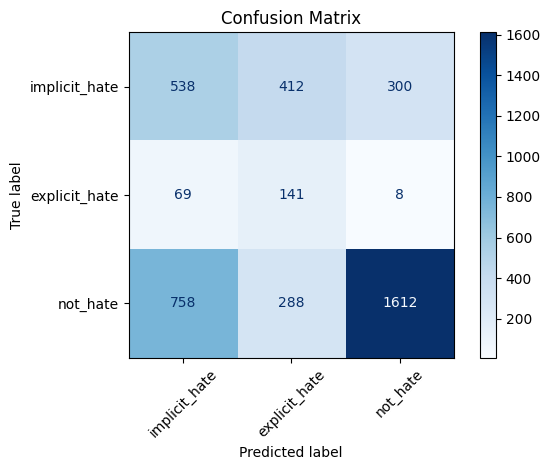

In [11]:
file_path = 'results_24shot_4126_PROMPT2_2.csv'  
df = pd.read_csv(file_path)

y_true = df['class'] 
y_pred = df['prediction'] 

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

labels = [
    'implicit_hate',
    'explicit_hate',
    'not_hate'
]

present_labels = [label for label in labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()